In [1]:
import urllib.request
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import copy

In [2]:
DEVICE = "cuda:0"
DATA_PATH = "data/"

In [3]:
class WineQuality(Dataset):
    def __init__(self, data_path="data/", version="white", train=True):
        # download and extract files
        url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
        file_name = url.split("/")[-1]
        if not os.path.exists(os.path.join(data_path, file_name)):
            urllib.request.urlretrieve(
                url, os.path.join(data_path, file_name)
            )
        if not os.path.exists(os.path.join(data_path, "wine+quality", "winequality-white.csv")):
            zipfile.ZipFile(os.path.join(data_path,  "wine+quality.zip")).extractall(
            os.path.join(data_path, "wine+quality")
            )
        # load  data and binarize
        df = pd.read_csv(os.path.join(data_path, "wine+quality", f"winequality-{version}.csv"), sep=";")
        y = df["quality"].to_numpy()
        X = df.drop(columns=["quality"]).to_numpy()
        y[y <= 5] = 0
        y[y >= 6] = 1

        np.random.seed(123)
        n = len(X)
        train_idx = np.random.choice(np.arange(n), size=(int(0.8 * n),), replace=False)
        test_idx = np.delete(np.arange(n), train_idx)
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test =  scaler.transform(X_test)
        if train:
            X = X_train
            y = y_train
        else:
            X = X_test
            y = y_test

        print(f"features shape: {X.shape}")
        print(f"targets shape: {y.shape}")
        self.features = torch.from_numpy(X).float()
        self.targets = torch.from_numpy(y).float().reshape(-1, 1)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, i):
        return self.features[i], self.targets[i]


In [4]:
def get_param_shapes(parameters):
    return [torch.tensor(p.shape) for p in parameters]

def get_num_parameters(param_shapes):
    return torch.tensor([torch.prod(s) for s in param_shapes]).sum().item()

def unflatten_gradient(g, param_shapes):
    chunks = torch.split(g, [torch.prod(s) for s in param_shapes])
    for i, chunk in enumerate(chunks):
        chunk = chunk.reshape(tuple(param_shapes[i]))
    return chunks

def flatten_parameters(parameters):
    return torch.cat([p.reshape(-1) for p in parameters])

class LinearModel(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        self.fc = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.fc(x)
    
class GradientModel(nn.Module):

    def __init__(self, n_inputs, n_outputs, n_parameters, hidden_size=512):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs + n_outputs + n_parameters, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_parameters)

    def forward(self, x, y, w):
        n = len(x)
        w = w.reshape(1, -1).expand([n, len(w)]) # copy to be n x d without additional memory
        h = F.relu(self.fc1(torch.cat([x, y, w], dim=1)))
        h = F.relu(self.fc2(h))
        return torch.mean(self.fc3(h), axis=0)

In [5]:
def train_one_epoch_func(dataloader, func_model, func_optimizer):
    floss = 0.0
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        loss.backward()
        func_optimizer.step()
        func_optimizer.zero_grad()
        floss += loss.item() / len(dataloader)
    return floss

@torch.no_grad()
def evaluate_func(dataloader, func_model):
    floss = 0.0
    acc = 0.0
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        floss += loss.item() / len(dataloader)
        acc += torch.mean((y.squeeze().to(DEVICE) == (logits.squeeze() >= 0).int()).float()).item() / len(dataloader)
    return floss, acc

def train_one_epoch_grad(dataloader, func_model, grad_model, grad_optimizer):
    gloss = 0.0
    param = flatten_parameters(func_model.parameters()).clone()
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())

        targets_true = flatten_parameters(grads).to(DEVICE)
        targets_pred = grad_model(x.to(DEVICE), y.to(DEVICE), param)
        error = F.mse_loss(targets_pred, targets_true)
        error.backward()

        grad_optimizer.step()
        grad_optimizer.zero_grad()
        gloss += error.item() / len(dataloader)
    return gloss

def evaluate_grad(dataloader, func_model, grad_model):
    gloss = 0.0
    param = flatten_parameters(func_model.parameters()).clone()
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())
        targets_true = flatten_parameters(grads).to(DEVICE)
        with torch.no_grad():
            targets_pred = grad_model(x.to(DEVICE), y.to(DEVICE), param)
            error = F.mse_loss(targets_pred, targets_true)
        gloss += error.item() / len(dataloader)
    return gloss

### Train Function and Gradient Model on Original Dataset

In [6]:
train_set =  WineQuality(version="white", data_path=DATA_PATH, train=True)
val_set = WineQuality(version="white", data_path=DATA_PATH, train=False)

d = train_set.features.shape[1]
c = train_set.targets.shape[1] if len(train_set.targets.shape) > 1 else 1
n_parameters = d + 1


features shape: (3918, 11)
targets shape: (3918,)
features shape: (980, 11)
targets shape: (980,)


In [7]:
n_epochs = 50
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

func_model = LinearModel(train_set.features.shape[1]).to(DEVICE)
param_shapes = get_param_shapes(func_model.parameters())
n_parameters = get_num_parameters(param_shapes)
grad_model = GradientModel(d, c, n_parameters, hidden_size=64).to(DEVICE)

func_optimizer = torch.optim.SGD(func_model.parameters(), lr=1e-2)
grad_optimizer = torch.optim.Adam(grad_model.parameters(), lr=1e-4)

func_train_loss = torch.zeros(n_epochs)
grad_train_loss = torch.zeros(n_epochs)
func_val_acc    = torch.zeros(n_epochs)
grad_val_loss   = torch.zeros(n_epochs)

torch.manual_seed(123)
for epoch in range(n_epochs):
    # train the function model for one epoch to learn the parameters
    func_train_loss[epoch] = train_one_epoch_func(train_loader, func_model, func_optimizer)
    # print(f"func train loss epoch {epoch:02d}: {func_train_loss[epoch]:0.5f}")
    _, func_val_acc[epoch] = evaluate_func(val_loader, func_model)
    # print(f"func valid acc epoch {epoch:02d}:  {func_val_acc[epoch]:0.5f}")

    # train the gradient model for one epoch
    grad_train_loss[epoch] = train_one_epoch_grad(train_loader, func_model, grad_model, grad_optimizer)
    # print(f"grad train loss epoch {epoch:02d}: {grad_train_loss[epoch]:0.5f}")
    grad_val_loss[epoch] = evaluate_grad(val_loader, func_model, grad_model)
    # print(f"grad valid loss epoch {epoch:02d}: {grad_val_loss[epoch]:0.5f}")
    # print()

Text(0, 0.5, 'Validation Loss')

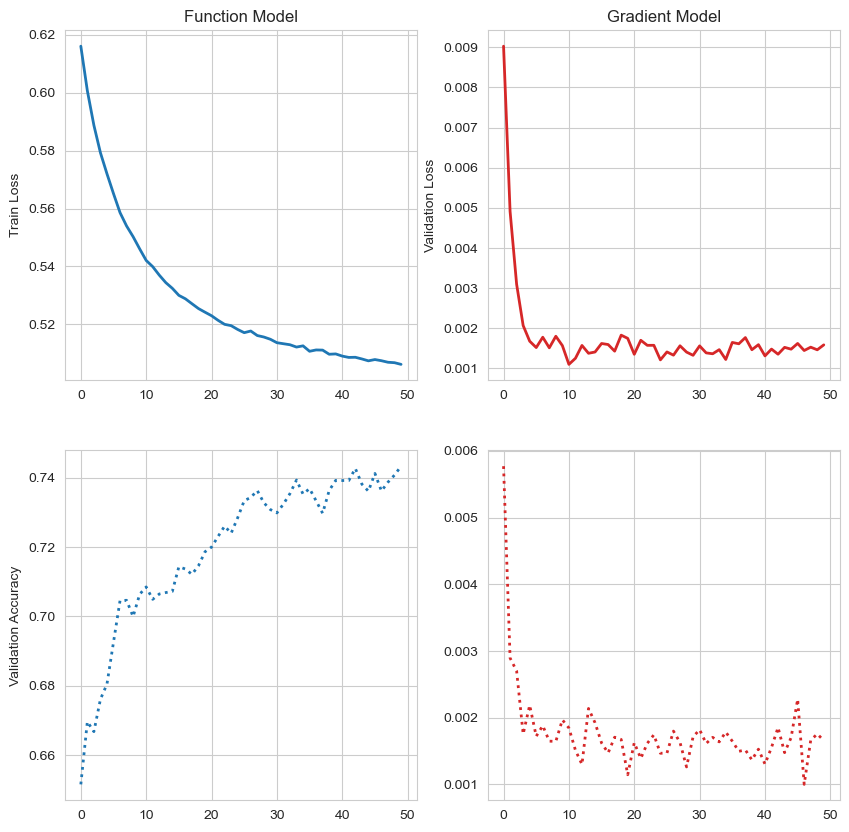

In [8]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

t = np.arange(n_epochs)

axes[0, 0].plot(t, func_train_loss, color="tab:blue", linewidth=2, linestyle="solid")
axes[0, 1].plot(t, grad_train_loss, color="tab:red", linewidth=2, linestyle="solid")
axes[1, 0].plot(t, func_val_acc, color="tab:blue", linewidth=2, linestyle="dotted")
axes[1, 1].plot(t, grad_val_loss, color="tab:red", linewidth=2, linestyle="dotted")

axes[0, 0].set_title("Function Model")
axes[0, 1].set_title("Gradient Model")

axes[0, 0].set_ylabel("Train Loss")
axes[0, 1].set_ylabel("Train Loss")
axes[1, 0].set_ylabel("Validation Accuracy")
axes[0, 1].set_ylabel("Validation Loss")

In [9]:
# check against sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = train_set.features.numpy()
y_train = train_set.targets.numpy().reshape(-1)
X_val = val_set.features.numpy()
y_val = val_set.targets.numpy().reshape(-1)

model = LogisticRegression(C=1000.0).fit(X_train, y_train)
print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_val, model.predict(X_val)))

0.7519142419601837
0.753061224489796


### Train Model on Related Dataset with No Backpropagation

In [10]:
train_set =  WineQuality(version="red", data_path=DATA_PATH, train=True)
val_set = WineQuality(version="red", data_path=DATA_PATH, train=False)

d = train_set.features.shape[1]
c = train_set.targets.shape[1] if len(train_set.targets.shape) > 1 else 1
n_parameters = d + 1

features shape: (1279, 11)
targets shape: (1279,)
features shape: (320, 11)
targets shape: (320,)


In [24]:
n_epochs = 100
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
model = LinearModel(train_set.features.shape[1]).to(DEVICE)
gmodel = copy.deepcopy(grad_model)

# find tune one epoch to improve the grad model
foptimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
goptimizer = torch.optim.Adam(gmodel.parameters(), lr=1e-4)

# for _ in range(5):
#     train_one_epoch_func(train_loader, model, foptimizer)
#     train_one_epoch_grad(train_loader, model, gmodel, goptimizer)

with torch.no_grad():
    
    param_shapes = get_param_shapes(model.parameters())

    lr = 0.01

    train_loss = torch.zeros(n_epochs)
    train_acc  = torch.zeros(n_epochs)
    val_loss   = torch.zeros(n_epochs)
    val_acc    = torch.zeros(n_epochs)

    torch.manual_seed(123)
    for epoch in range(n_epochs):
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            param = flatten_parameters(model.parameters())
            grad = gmodel(x.to(DEVICE), y.to(DEVICE), param)

            param -= lr * grad
            new_param = unflatten_gradient(param, param_shapes)
            # state_dict = model.state_dict()
            for i, p in enumerate(model.parameters()):
                p.copy_(new_param[i])

        train_loss[epoch], train_acc[epoch] = evaluate_func(train_loader, model)
        val_loss[epoch], val_acc[epoch] = evaluate_func(val_loader, model)

        if epoch % 20 == 0:
            with torch.enable_grad():
                train_one_epoch_grad(train_loader, model, gmodel, goptimizer)

print(train_loss[-10:])
print(train_acc[-10:])
print(val_loss[-10:])
print(val_acc[-10:])

tensor([0.5832, 0.5821, 0.5809, 0.5799, 0.5789, 0.5779, 0.5770, 0.5761, 0.5753,
        0.5745])
tensor([0.6841, 0.6818, 0.6802, 0.6802, 0.6787, 0.6755, 0.6786, 0.6826, 0.6841,
        0.6857])
tensor([0.5598, 0.5555, 0.5569, 0.5524, 0.5589, 0.5411, 0.5486, 0.5381, 0.5462,
        0.5414])
tensor([0.7370, 0.7474, 0.7396, 0.7370, 0.7448, 0.7474, 0.7474, 0.7474, 0.7526,
        0.7396])


Text(0, 0.5, 'Accuracy')

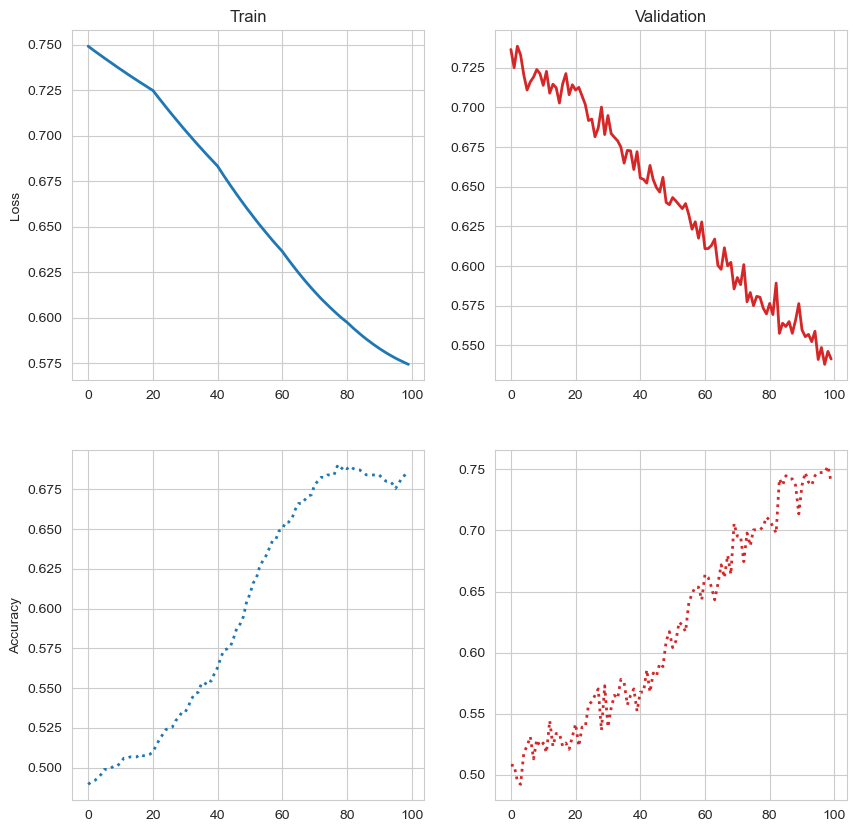

In [25]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

t = np.arange(n_epochs)

axes[0, 0].plot(t, train_loss, color="tab:blue", linewidth=2, linestyle="solid")
axes[0, 1].plot(t, val_loss, color="tab:red", linewidth=2, linestyle="solid")
axes[1, 0].plot(t, train_acc, color="tab:blue", linewidth=2, linestyle="dotted")
axes[1, 1].plot(t, val_acc, color="tab:red", linewidth=2, linestyle="dotted")

axes[0, 0].set_title("Train")
axes[0, 1].set_title("Validation")

axes[0, 0].set_ylabel("Loss")
axes[1, 0].set_ylabel("Accuracy")

In [26]:
# check against sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = train_set.features.numpy()
y_train = train_set.targets.numpy().reshape(-1)
X_val = val_set.features.numpy()
y_val = val_set.targets.numpy().reshape(-1)

model_ = LogisticRegression(C=1000.0).fit(X_train, y_train)
print(accuracy_score(y_train, model_.predict(X_train)))
print(accuracy_score(y_val, model_.predict(X_val)))

0.7372947615324472
0.76875
